In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from matplotlib.ticker import FormatStrFormatter
import re
import os
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import math

In [2]:
txt_files = ['Figure 1 (2024 ON).txt']
columns = ['Date__(UT)__HR:MN', '', '', ' R.A._(ICRF)', 'DEC__(ICRF)', 'delta', '     deldot', '']

for file_path in txt_files:
    start_marker = "$$SOE"
    end_marker = "$$EOE"
    
    with open(file_path, 'r') as file:
        data_lines = []
        is_data = False 
        
        for line in file:
            if start_marker in line:
                is_data = True
            elif end_marker in line:
                is_data = False
            elif is_data:
                data_lines.append(line.strip())
    
    data = [line.split(",") for line in data_lines]
    max_columns = max(len(row) for row in data)
    data = [row + [''] * (max_columns - len(row)) for row in data]
    df = pd.DataFrame(data, columns=columns)
    
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    csv_file_path = f'{base_name}.csv'
    df.to_csv(csv_file_path, index=False)
    print(f"Excel file saved: {csv_file_path}")

Excel file saved: Figure 1 (2024 ON).csv


In [3]:
file_path = 'Figure 1 (2024 ON).csv'
data = pd.read_csv(file_path)
print(data.to_string(index=False))

 Date__(UT)__HR:MN Unnamed: 1 Unnamed: 2   R.A._(ICRF)  DEC__(ICRF)    delta       deldot  Unnamed: 7
      2.460558e+06                     m     269.09732      5.56963 0.063274    -8.567432         NaN
      2.460559e+06                           269.09347      5.55039 0.063069    -8.465509         NaN
      2.460559e+06                           269.09038      5.53081 0.062867    -8.372713         NaN
      2.460559e+06                           269.08862      5.51092 0.062666    -8.295454         NaN
      2.460559e+06                           269.08863      5.49074 0.062467    -8.239074         NaN
      2.460559e+06                           269.09079      5.47034 0.062269    -8.207475         NaN
      2.460559e+06                           269.09529      5.44975 0.062072    -8.202861         NaN
      2.460559e+06                           269.10218      5.42904 0.061874    -8.225582         NaN
      2.460559e+06                           269.11137      5.40827 0.061676    -8

In [4]:
jd_adjusted = data['Date__(UT)__HR:MN']
jd_binned_median = jd_adjusted - jd_adjusted.min()

ra_deg_adjusted_detected = data[' R.A._(ICRF)']

print(f"{'JD Adjusted':<25}{'RA Adjusted Detected':<25}")
print("=" * 75)

for jd, ra in zip(jd_binned_median, ra_deg_adjusted_detected):
    print(f"{jd:<25.10f}{ra:<25.10f}")

JD Adjusted              RA Adjusted Detected     
0.0000000000             269.0973200000           
0.0416666670             269.0934700000           
0.0833333330             269.0903800000           
0.1250000000             269.0886200000           
0.1666666670             269.0886300000           
0.2083333330             269.0907900000           
0.2500000000             269.0952900000           
0.2916666670             269.1021800000           
0.3333333330             269.1113700000           
0.3750000000             269.1225800000           
0.4166666670             269.1354300000           
0.4583333330             269.1494000000           
0.5000000000             269.1639100000           
0.5416666670             269.1783500000           
0.5833333330             269.1920900000           
0.6250000000             269.2045800000           
0.6666666670             269.2153200000           
0.7083333330             269.2239600000           
0.7500000000             269.23

In [5]:
#  Equation 5
def fit_function_linear(x, A, B, C, D, E):
    return A * np.sin(2 * np.pi * x + B) + C * x + D + E * x**2

params_sine, covariance_sine = curve_fit(fit_function_linear, jd_binned_median, ra_deg_adjusted_detected)
print(f"\033[1;32m Equation 1: sine +linear terms (Paramters):     {params_sine}\033[0m")

# Uncertainties in Equation 5
sine_uncertainties = np.sqrt(np.diag(covariance_sine))
print(f"\033[1;32m Equation 1: sine +linear terms (Uncertainities):{sine_uncertainties}\033[0m")

 Equation 1: sine +linear terms (Paramters):     [-3.64918244e-02  9.21071029e-02  1.05444489e-01  2.69102673e+02
  2.22956978e-02]
 Equation 1: sine +linear terms (Uncertainities):[0.00017474 0.00453987 0.00079951 0.00034268 0.00039335]


In [6]:
amplitude_deg = params_sine[0]
amplitude_rad = math.radians(amplitude_deg)
print(f"\033[1;32mamplitude (rad):              {amplitude_rad}\033[0m")
 
amplitude_uncertainty_deg = sine_uncertainties[0]
amplitude_uncertainty_rad = math.radians(amplitude_uncertainty_deg)
print(f"\033[1;32mamplitude uncertianity (rad): {amplitude_uncertainty_rad}\033[0m")

amplitude (rad):              -0.0006369024866501673
amplitude uncertianity (rad): 3.049828048392802e-06


In [7]:
earth_radius_km = 6371  

distance_km = earth_radius_km / amplitude_rad

distance_uncertainty_km = (earth_radius_km/amplitude_rad) * (amplitude_uncertainty_rad/abs(amplitude_rad))

print(f"\033[1;32mEquation 3: Distance_km: {abs(distance_km):.2f} ± {abs(distance_uncertainty_km):.2f}\033[0m")

Equation 3: Distance_km: 10003101.16 ± 47900.17


In [8]:
latitude_deg = 30.1732 
latitude_rad = math.radians(latitude_deg)
print("Latitude (rad):              ", latitude_rad)

Latitude (rad):               0.526621685862753


In [9]:
dec_deg = data['DEC__(ICRF)'][0]
dec_rad = math.radians(dec_deg)
print("DEC (rad):                   ", dec_rad)

DEC (rad):                    0.09720838161785178


In [10]:
asteroid_km = (distance_km * math.cos(latitude_rad)) / math.cos(dec_rad)

asteroid_uncertainty_km = asteroid_km * (distance_uncertainty_km / distance_km)

print(f"\033[1;32mEquation 4: Asteroid Distance (km):{abs(asteroid_km):.2f} ± {abs(asteroid_uncertainty_km):.2f}\033[0m")

Equation 4: Asteroid Distance (km):8688800.88 ± 41606.60


In [11]:
km_to_au = 149597870.7

asteroid_dist_au = asteroid_km / km_to_au

asteroid_dist_uncertainty_au = asteroid_uncertainty_km / km_to_au

print(f"\033[1;32mAsteroid Distance (AU):{abs(asteroid_dist_au):.6f} ± {abs(asteroid_dist_uncertainty_au):.6f}\033[0m")

Asteroid Distance (AU):0.058081 ± 0.000278


In [12]:
delta = data['delta']
true_distance = delta.mean()
print(f"\033[1;32mNASA JPL Horizons True distance (AU): {true_distance}\033[0m")

NASA JPL Horizons True distance (AU): 0.0584422349156204


In [13]:
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(asteroid_dist_au) - abs(true_distance)) / ((abs(asteroid_dist_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mAsteroid Distance Difference between True and Predicted: {percentage_difference:.6f}%\033[0m")

Asteroid Distance Difference between True and Predicted: 0.619942%


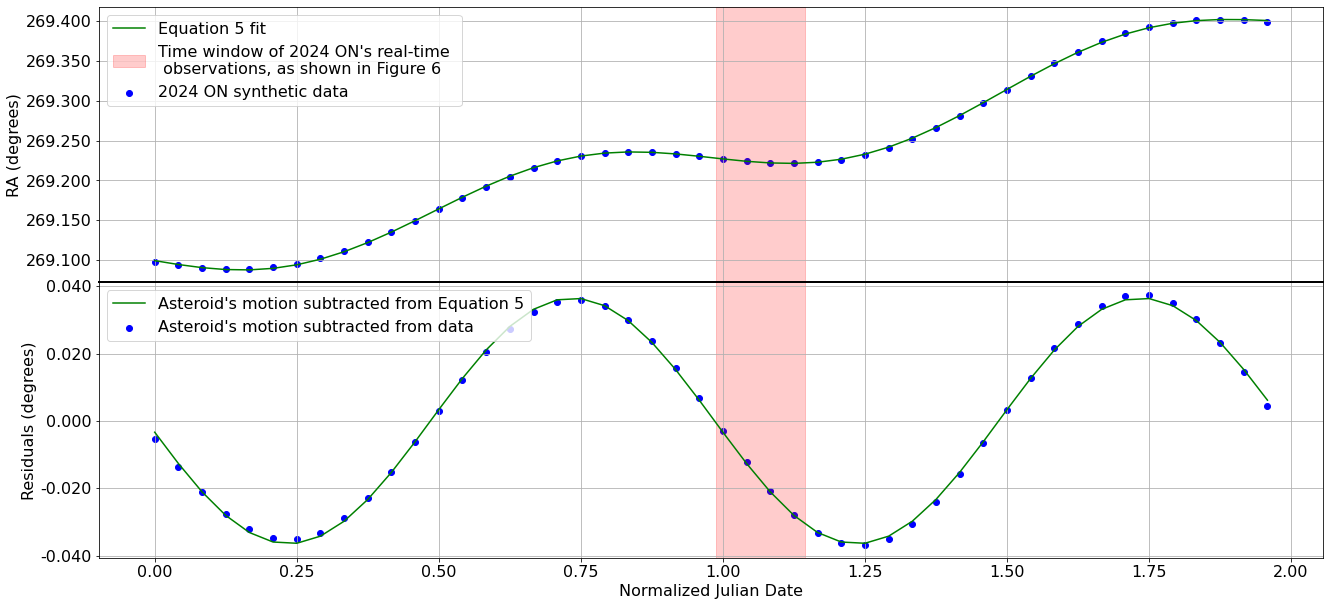

In [14]:
radians_to_degrees = 180 / np.pi
#highlight_rows = slice(23, 29)
#legend_label = "Observations of 2024 ON, as shown in Figure 6"

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 1, height_ratios=[1.5, 1.5, 1], figure=fig)

# Subplot 1: 
ax1 = fig.add_subplot(gs[0, 0])

ax1.scatter(jd_binned_median, ra_deg_adjusted_detected, color='blue', label = '2024 ON synthetic data')
ax1.plot(jd_binned_median, fit_function_linear(jd_binned_median, *params_sine), color='green', label = 'Equation 5 fit')
ax1.axvspan(0.988, 1.144, color='red', alpha=0.2, label="Time window of 2024 ON's real-time \n observations, as shown in Figure 6")

ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel("RA (degrees)", fontsize=16)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xticklabels([])
ax1.legend(fontsize=16)
ax1.grid()

# Subplot 2: 
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(jd_binned_median, 
         fit_function_linear(jd_binned_median, *params_sine) - (params_sine[2]*jd_binned_median + params_sine[3] + params_sine[4]*jd_binned_median**2), 
         color = 'green', label = 'Asteroid\'s motion subtracted from Equation 5')
ax2.scatter(jd_binned_median, ra_deg_adjusted_detected - (params_sine[2]*jd_binned_median + params_sine[3] + params_sine[4]*jd_binned_median**2), 
            color = 'blue', label = 'Asteroid\'s motion subtracted from data')
ax2.axvspan(0.988, 1.144, color='red', alpha=0.2)

ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xlabel("Normalized Julian Date", fontsize=16)
ax2.set_ylabel("Residuals (degrees)", fontsize=16) 
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.legend(fontsize=16)
ax2.grid()
plt.subplots_adjust(hspace=0)
plt.gcf().axes[0].spines['bottom'].set_linewidth(2)
plt.gcf().axes[1].spines['top'].set_linewidth(2)
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.1, hspace=0)
plt.savefig("Figure 1.png", format="png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()